In [601]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [602]:
data15 = pd.read_csv("~/Documents/Data/NNRB/finaldata/Batch1thetatau.csv")
data15.head()

,Time,Temp
0,0,77.40651
1,10,81.71672
2,20,88.27853
3,30,92.03464
4,40,95.95712


<Axes: >

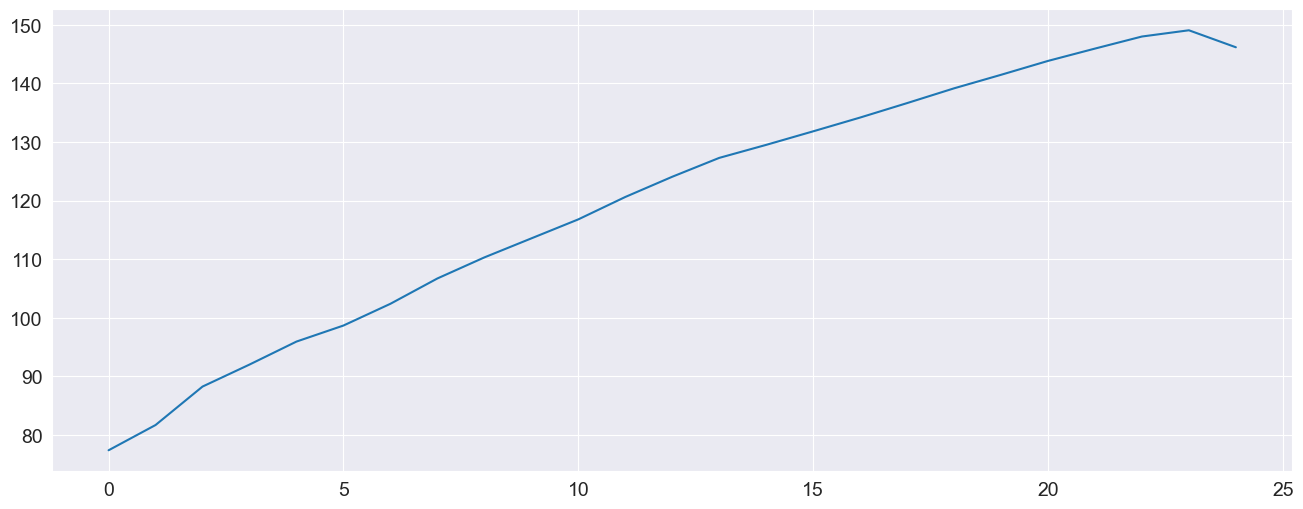

In [603]:
data15.Temp.plot()

## QQ Plot

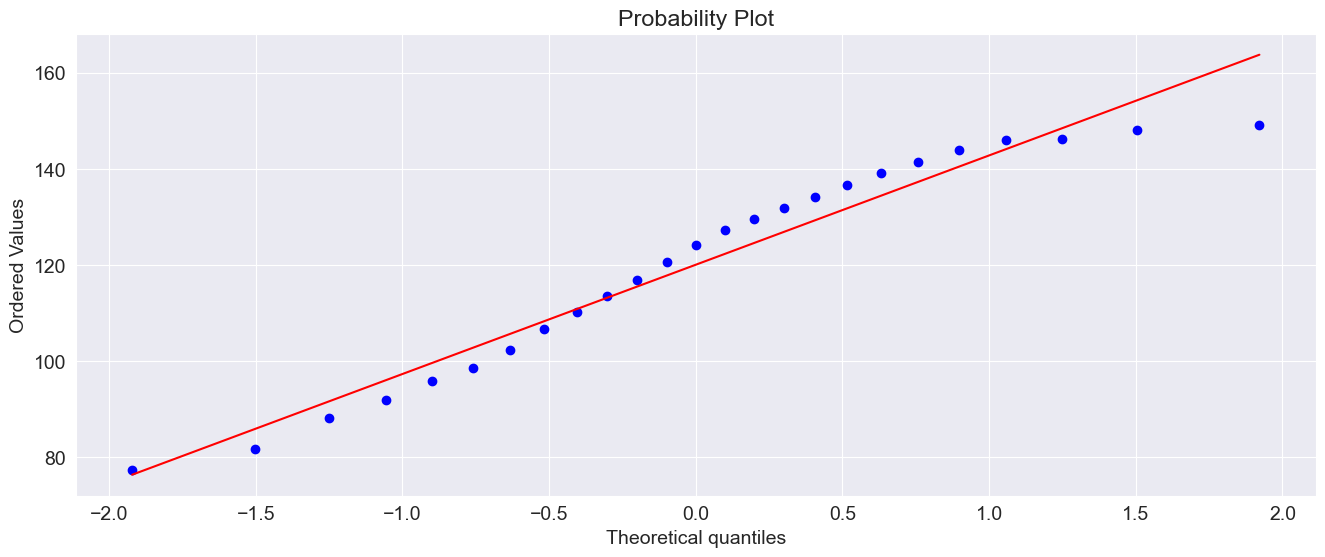

In [604]:
scipy.stats.probplot(data15.Temp, plot=pylab)
pylab.show()

In [605]:
data15.Time.describe()

count     25.000000
mean     120.000000
std       73.598007
min        0.000000
25%       60.000000
50%      120.000000
75%      180.000000
max      240.000000
Name: Time, dtype: float64

In [606]:
data15['Time'] = pd.to_datetime(data15['Time'] * 60, unit='s')
data15['Time'] = data15['Time'].dt.time
data15_comp = data15.copy()
data15.head

<bound method NDFrame.head of         Time        Temp
0   00:00:00   77.406510
1   00:10:00   81.716720
2   00:20:00   88.278530
3   00:30:00   92.034640
4   00:40:00   95.957120
5   00:50:00   98.693790
6   01:00:00  102.406006
7   01:10:00  106.727280
8   01:20:00  110.319283
9   01:30:00  113.565468
10  01:40:00  116.809425
11  01:50:00  120.631264
12  02:00:00  124.083107
13  02:10:00  127.302208
14  02:20:00  129.524750
15  02:30:00  131.835709
16  02:40:00  134.187653
17  02:50:00  136.653870
18  03:00:00  139.173737
19  03:10:00  141.481339
20  03:20:00  143.852400
21  03:30:00  145.957047
22  03:40:00  148.015762
23  03:50:00  149.082047
24  04:00:00  146.181366>

In [607]:
data15.set_index('Time', inplace=True)
data15.head()

,Temp
Time,
00:00:00,77.40651
00:10:00,81.71672
00:20:00,88.27853
00:30:00,92.03464
00:40:00,95.95712


In [608]:
size = int(len(data15) * 0.8)
data15 = data15_comp.iloc[:size]
data15_test = data15_comp.iloc[size:]
data15.tail()

,Time,Temp
15,02:30:00,131.835709
16,02:40:00,134.187653
17,02:50:00,136.653870
18,03:00:00,139.173737
19,03:10:00,141.481339


In [609]:
data15_test.head()

,Time,Temp
20,03:20:00,143.852400
21,03:30:00,145.957047
22,03:40:00,148.015762
23,03:50:00,149.082047
24,04:00:00,146.181366


### Stationarity

In [610]:
sts.adfuller(data15_comp.Temp)

(2.3650596200132656,
 0.998992906304938,
 9,
 15,
 {'1%': -3.9644434814814815,
  '5%': -3.0849081481481484,
  '10%': -2.6818144444444445},
 39.80753400231728)

### ACF

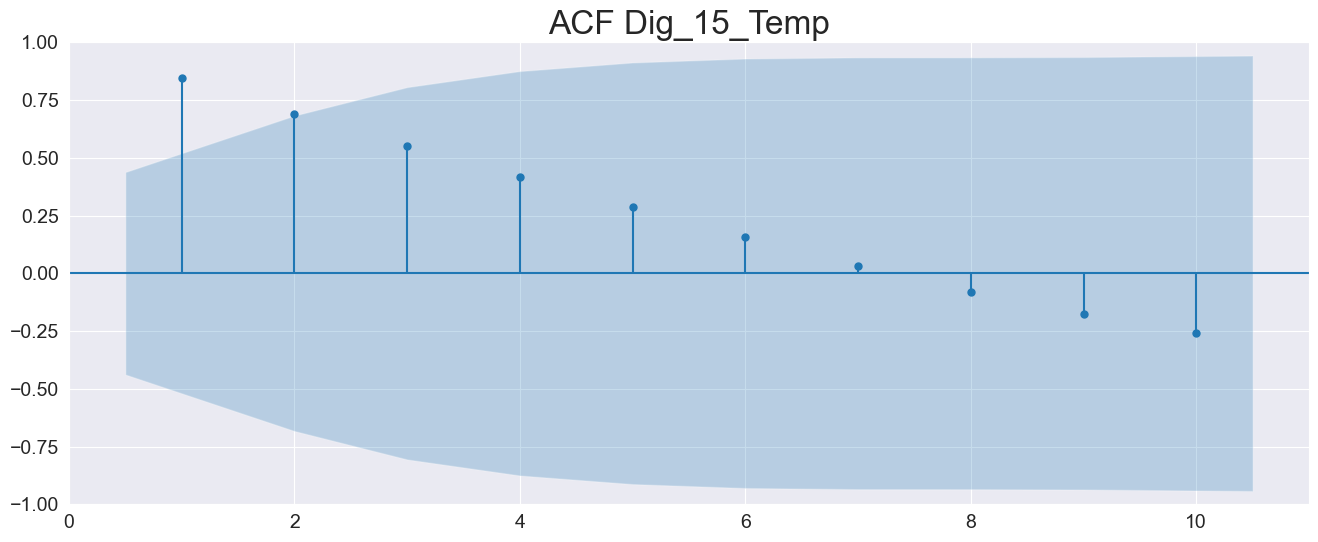

In [611]:
sgt.plot_acf(data15.Temp, lags = 10, zero = False)
plt.title("ACF Dig_15_Temp", size = 24)
plt.show()

### PACF

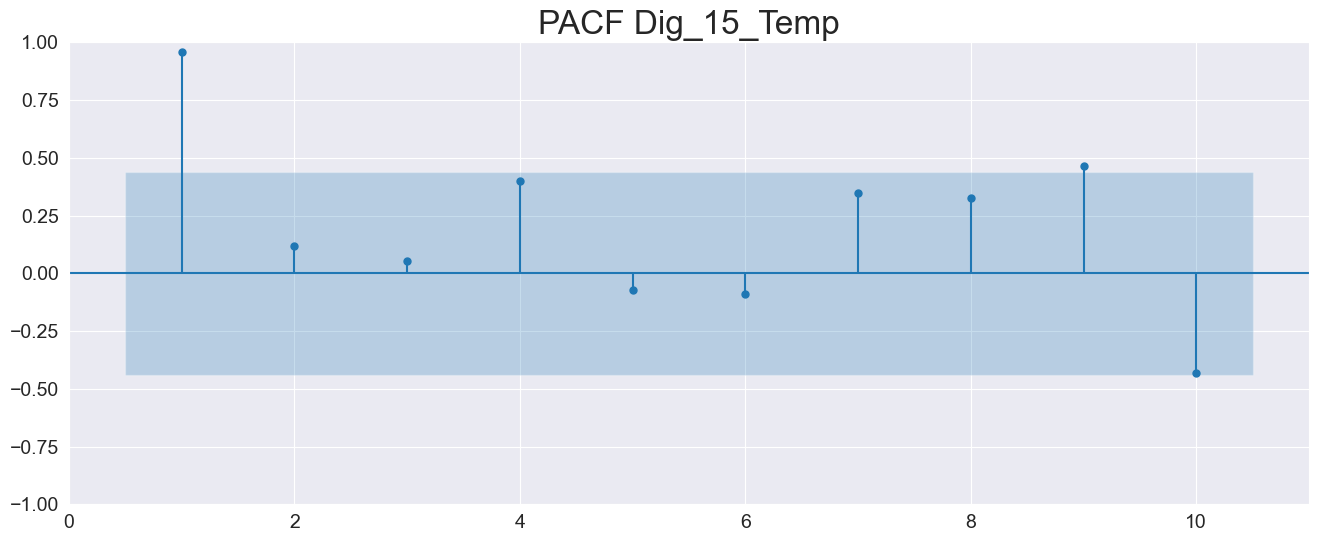

In [612]:
sgt.plot_pacf(data15.Temp, lags = 10, zero = False, method = ('ols'))
plt.title("PACF Dig_15_Temp", size = 24)
plt.show()

### AR Models

In [613]:
#AR1
model_temp_ar1 = ARIMA(data15.Temp, order=(2, 0, 0))
results_ar = model_temp_ar1.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Temp   No. Observations:                   20
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -32.824
Date:                Wed, 21 Feb 2024   AIC                             73.649
Time:                        00:05:49   BIC                             77.632
Sample:                             0   HQIC                            74.426
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6586     75.508      1.373      0.170     -44.335     251.652
ar.L1          1.9455      0.156     12.442      0.000       1.639       2.252
ar.L2         -0.9529      0.143     -6.672      0.000      -1.233      -0.673
sigma2         0.9625      0.282      3.408      0.001       0.409       1.516
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.15   Prob(JB):                         0.14
Heteroskedasticity (H):               0.07   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Validation

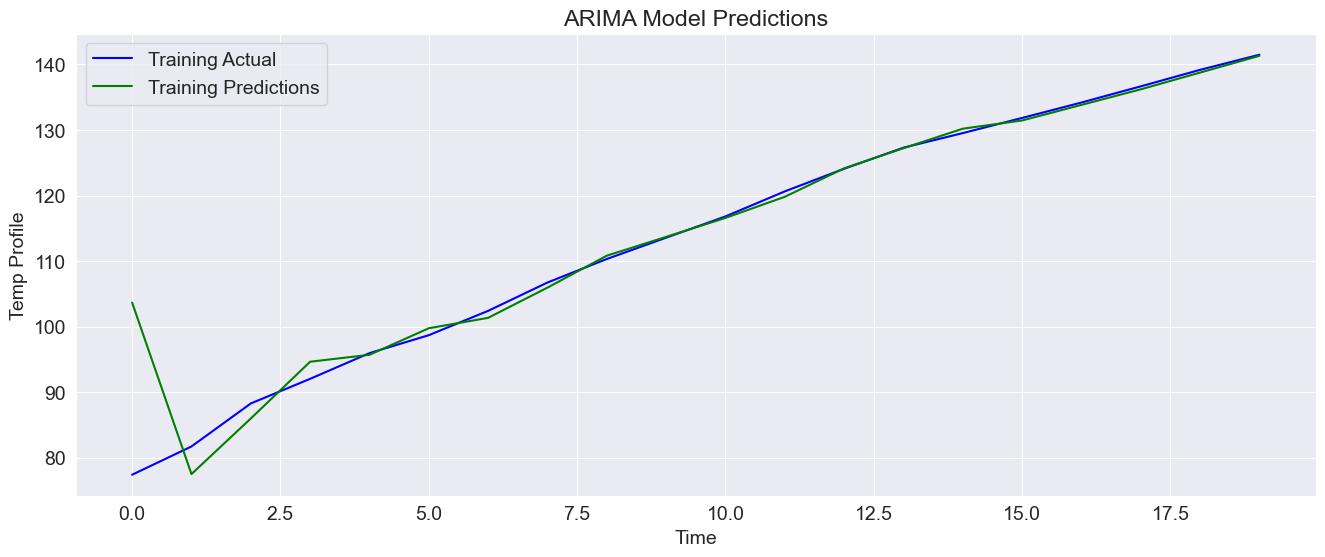

In [614]:
# Make predictions on training dataset
train_predictions = pd.DataFrame(results_ar.predict(n_periods = len(data15)), index = data15.index)
#print(train_predictions)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_ar.forecast(steps=len(data15_test)))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15.index, data15['Temp'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15.index, train_predictions, color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('Temp Profile')
plt.legend()

# Show plot
plt.show()

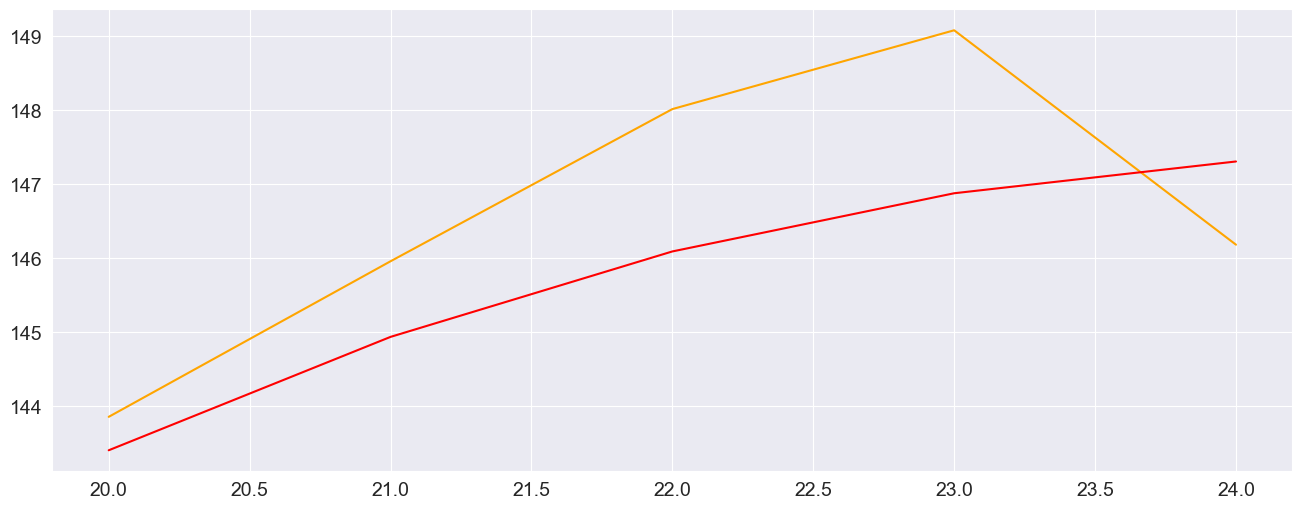

In [615]:
# Plot test data
plt.plot(data15_test.index, data15_test['Temp'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### Exogenous inputs

In [ ]:
#AR2
model_temp_ar1 = ARIMA(data15.Temp, exog=(), order=(2, 0, 0))
results_ar = model_temp_ar1.fit()
results_ar.summary()